In [34]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 데이터 불러오기

In [35]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### Train, Val Dataset 비율 변경

In [36]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### 데이터 확인

In [37]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[50]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0151-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1619_bacteria_4271.jpeg


### Normal과 Pneumonia 비율

In [38]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1094
Pneumonia images count in training set: 3091


# Dataset 생성

### Path 리스트르 Tensor로 변환

In [39]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

print(train_list_ds)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

<TensorSliceDataset shapes: (), types: tf.string>
Training images count: 4185
Validating images count: 1047


### Path 리스트에서 image 리스트로 변환

In [40]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train_dataset = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_dataset = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

print(train_ds)

<PrefetchDataset shapes: ((None, None, 180, 180, 3), (None, None)), types: (tf.float32, tf.bool)>


### Dataset 확인

In [41]:
for image, label in train_dataset.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


### Test Dataset 생성

In [42]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 학습을 위한 최적의 Dataset

In [43]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 무작위로 섞기
    ds = ds.repeat()                                 
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_dataset)
val_ds = prepare_for_training(val_dataset)

train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

### Dataset 시각화

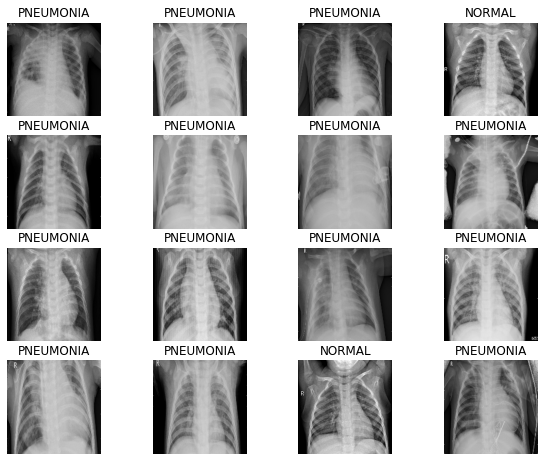

In [11]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Model

### Model 생성

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Data Imbalance 해결

In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.98
Weight for PNEUMONIA: 0.67


# 학습

### Compile

In [19]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [20]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 54s 143ms/step - loss: 0.5607 - accuracy: 0.6972 - precision: 0.9044 - recall: 0.6636 - val_loss: 0.7098 - val_accuracy: 0.7212 - val_precision: 0.7212 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 36s 136ms/step - loss: 0.2255 - accuracy: 0.9020 - precision: 0.9679 - recall: 0.8976 - val_loss: 1.5181 - val_accuracy: 0.7192 - val_precision: 0.7192 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 36s 136ms/step - loss: 0.2242 - accuracy: 0.9215 - precision: 0.9741 - recall: 0.9194 - val_loss: 0.3920 - val_accuracy: 0.8067 - val_precision: 0.7882 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 36s 136ms/step - loss: 0.1714 - accuracy: 0.9396 - precision: 0.9739 - recall: 0.9427 - val_loss: 0.7639 - val_accuracy: 0.7885 - val_precision: 1.0000 - val_recall: 0.7051
Epoch 5/25
261/261 [==============================] - 35s 135ms/step - loss: 0.1749 - accura

### 학습 결과

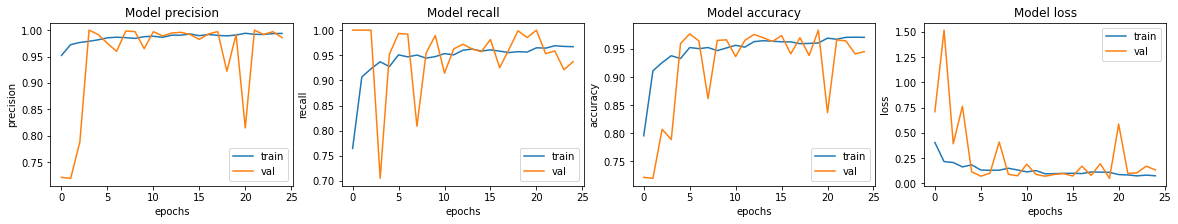

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 평가

In [22]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.6756 - accuracy: 0.8413 - precision: 0.8156 - recall: 0.9641
Loss: 0.6755533814430237,
Accuracy: 0.8413461446762085,
Precision: 0.8156182169914246,
Recall: 0.964102566242218


# 정확도 향상을 위한 노력

1. Hyper Parameters
2. Data Augmentation
3. Imblance Usage

### Train 및 Test 메소드 생성

In [ ]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

### 위 과정 한 한 번에 실행

In [61]:
def attempt(train_ds=train_dataset, val_ds=val_dataset,
            BATCH_SIZE=16, EPOCHS=25, 
            optimizer='adam', loss_fn='binary_crossentropy', 
            weight=True, augmentation=False):
    
    train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

    test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
    TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
    test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE)

    def augment(image,label):
        image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
        return image,label

    def prepare_for_training(ds, shuffle_buffer_size=1000):
        # augment 적용 부분이 배치처리 함수에 추가되었습니다.
        if augmentation:
            ds = ds.map(
                    augment,       # augment 함수 적용
                    num_parallel_calls=2
                )
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        ds = ds.repeat()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds

    train_ds = prepare_for_training(train_ds)
    val_ds = prepare_for_training(val_ds)

    with tf.device('/GPU:0'):
        model = build_model()
        
        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
        
        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=METRICS)
            
        history = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=val_ds,
            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
            verbose=0)
        
    condition = {
        'batch_size' : BATCH_SIZE,
        'epochs' : EPOCHS,
        'loss_fn' : loss_fn,
        'optimizer' : optimizer,
        'class_weight' : class_weight,
        'augmentation' : augmentation}
    
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall}')
    
    eval_result = {
        'loss' : loss,
        'accuracy' : accuracy,
        'precision' : precision,
        'recall' : recall}
    
    return history, eval_result, condition

### Hyper Parameters 수정 후 학습

In [63]:
history_normal = attempt()                          # 기본값
history_optimizer = attempt(optimizer='sgd')        # Optimizer SGD로 변경
history_batch = attempt(BATCH_SIZE=4)               # Batch size 4로 변경
history_epochs = attempt(EPOCHS=40)                 # epoch 40으로 변경
history_augmentation = attempt(augmentation=True)  # Augmentation 실시

39/39 [==============================] - 3s 75ms/step - loss: 1.6202 - accuracy: 0.8029 - precision: 0.7602 - recall: 1.0000
Loss: 1.6202231645584106 | Accuracy: 0.8028846383094788 | Precision: 0.7602339386940002 | Recall: 1.0
39/39 [==============================] - 3s 77ms/step - loss: 0.7464 - accuracy: 0.8381 - precision: 0.8162 - recall: 0.9564
Loss: 0.7464088797569275 | Accuracy: 0.8381410241127014 | Precision: 0.8161925673484802 | Recall: 0.9564102292060852


### Hyper Parameters 수정 결과

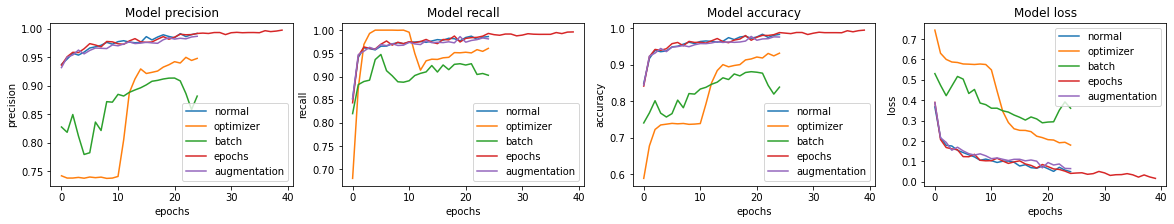

In [75]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

history_list = [history_nomal, history_optimizer, history_batch, history_epochs, history_augmentation]
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    for history in history_list:
        ax[i].plot(history[0].history[met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['normal', 'optimizer', 'batch', 'epochs', 'augmentation'])

In [89]:
for history in history_list:
    print(history[1]['accuracy'])

0.8782051205635071
0.7179487347602844
0.6810897588729858
0.8028846383094788
0.8381410241127014


### 모두 동시에

In [77]:
history_all = attempt(optimizer='sgd', EPOCHS=40, augmentation=True)

39/39 [==============================] - 3s 74ms/step - loss: 0.6602 - accuracy: 0.7740 - precision: 0.7380 - recall: 0.9897
Loss: 0.6601510643959045 | Accuracy: 0.7740384340286255 | Precision: 0.7380496859550476 | Recall: 0.9897435903549194


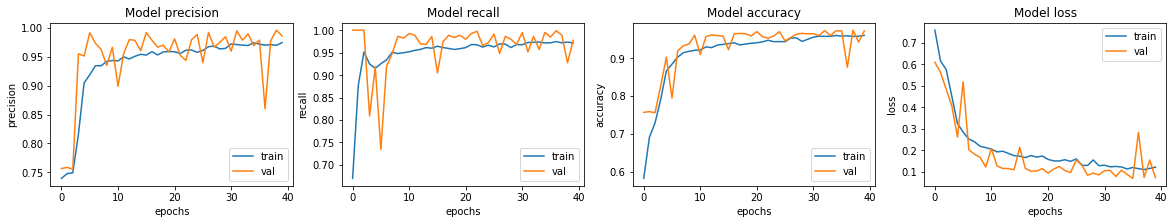

In [85]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_all[0].history[met])
    ax[i].plot(history_all[0].history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [90]:
history_all[1]['accuracy']

0.7740384340286255

# 결과 및 고찰
- 다양한 방법을 사용해서 차이를 확인했지만, 그냥 일반적인 경우에서 가장 좋은 결과가 나왔다.
- Seed에 의해 같은 방식과 모델로도 랜덤성에 의해 83%~87%의 정확도를 보였다.
- 신기하게 Recall수치는 계속 높게 나오는데, 다행히 병 진단의 경우 Recall이 높은 경우가 더 좋기 때문에 좋은 성능이라고 할 수 있을 것 같다.
- Hyper Parameters를 수정해도 비슷한 결과가 나온다면, 결국 이미지 전처리를 통해서 성능을 높일 수 있을 것 같다.